In [1]:
import pyxdf
import mne
import numpy as np
import pandas as pd
import random

In [2]:
# สร้าง list เพื่อเก็บ index ของ epoch ที่ต้องการลบ event_id ออก
def count_each_class(mne_epochs, num_class):
    indices_to_drop = []
    num_class = num_class

    # Iterate ผ่านทุกๆ epoch
    for idx, epoch in enumerate(mne_epochs):
        # ตรวจสอบว่า event_id เป็น {'natural': 0} หรือไม่
        if mne_epochs.events[idx, -1] == num_class:  # ตรวจสอบ event_id ในข้อมูล events ของ epoch นั้นๆ
            # เพิ่ม index ของ epoch ที่ต้องการลบออกใน list
            indices_to_drop.append(idx)

    # ลบ epoch ที่มี event_id เป็น {'natural': 0} ออกจาก mne_epochs
    return indices_to_drop
    # mne_epochs.drop(indices_to_drop)

In [3]:
def random_drop_to_balance(mne_epochs, class_counts):
    # หาจำนวนของ class ที่มีจำนวนน้อยสุด
    # print(class_counts)
    min_count = min(class_counts)
    
    # สร้าง list เพื่อเก็บ index ของแต่ละ class
    class_indices = [[] for _ in range(len(class_counts))]

    # นับ index ของแต่ละ class
    for idx, epoch in enumerate(mne_epochs):
        event_id = mne_epochs.events[idx, -1]
        class_indices[event_id].append(idx)

    # สุ่มลำดับ index ของแต่ละ class เพื่อทำการลบ
    random_indices_to_drop = []
    for indices in class_indices:
        # สุ่มลำดับ index ที่ต้องการลบออก
        if len(indices) > len(min_count):
            random_indices = random.sample(indices, len(indices) - len(min_count))
            random_indices_to_drop.extend(random_indices)
    
    # ลบ epoch ที่ต้องการออกจาก mne_epochs
    mne_epochs.drop(random_indices_to_drop)

    return random_indices_to_drop

In [35]:
streams, header = pyxdf.load_xdf("C:/Users/Toey/Desktop/data_ssvep/Toey/exp1/block_1.xdf")
# streams, header = pyxdf.load_xdf("C:/Users/Toey/Downloads/single flicker SSVEP BCI raw data/3.raw_data/1.training_data/sub_1_1.xdf")

In [36]:
streams[0]

{'info': defaultdict(list,
             {'name': ['obci_eeg1'],
              'type': ['EEG'],
              'channel_count': ['8'],
              'nominal_srate': ['250'],
              'channel_format': ['float32'],
              'source_id': ['openbcigui'],
              'version': ['1.1000000000000001'],
              'created_at': ['97866.327942699994'],
              'uid': ['2e5886a9-33e7-4ade-be69-41ca8fd3a01e'],
              'session_id': ['default'],
              'hostname': ['DESKTOP-5KJIQRK'],
              'v4address': [None],
              'v4data_port': ['16572'],
              'v4service_port': ['16572'],
              'v6address': [None],
              'v6data_port': ['16572'],
              'v6service_port': ['16572'],
              'desc': [None],
              'stream_id': 1,
              'effective_srate': 250.31304395127165}),
 'footer': {'info': defaultdict(list,
              {'first_timestamp': ['100022.3090931'],
               'last_timestamp': ['101348.34

In [37]:
# streams, header = pyxdf.load_xdf("C:/Users/Toey/Desktop/data_ssvep/Toey/exp1/block_1.xdf")
raw_data = streams[0]["time_series"].T #From Steam variable this query is EEG data
event_index = np.array(streams[1]["time_series"]).T[0]
# event_index = streams[1]["time_series"].T #Get all event marker of experiment 

In [38]:
event_index

array([1, 0, 2, 0, 3, 0, 4, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 0, 1, 0, 2, 0,
       3, 0, 4, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0,
       0, 1, 0, 2, 0, 3, 0, 4, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 0, 1, 0, 2,
       0, 3, 0, 4, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 0, 1, 0, 2, 0, 3, 0, 4,
       0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 0, 0])

In [166]:
raw_mne

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [40]:
# Transpose the raw EEG data and event markers
raw_data = streams[0]["time_series"].T  # From Steam variable this query is EEG data
event_index = np.array(streams[1]["time_series"]).T[0]  # Get all event marker of experiment
event_timestamp = streams[1]["time_stamps"].T  # Timestamp when event marked

# Set the target EEG channel names
channels = [str(i) for i in range(1, len(raw_data) + 1)]

# Create MNE info structure
info = mne.create_info(
    ch_names=channels,
    ch_types=['eeg'] * len(channels),
    sfreq=250  # OpenBCI Frequency acquisition
)

# Create MNE RawArray
raw_mne = mne.io.RawArray(raw_data, info, verbose=False)

# Create a mapping from string event markers to integers
# event_mapping = {
#     '0': 1,  # natural
#     'N': 2,  # north
#     'E': 3,  # east
#     'S': 4,  # south
#     'W': 5   # west
# }
events = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))

fre1 = 8
fre2 = 10
fre3 = 12
fre4 = 14
events_id = { 
     f'natural': 0,
     f'Frequency {fre1} Hz': 1,
     f'Frequency {fre2} Hz': 2,
     f'Frequency {fre3} Hz': 3,
     f'Frequency {fre4} Hz': 4,
}

# # Convert string event markers in event_index to integers using the mapping
# event_index_int = np.array([event_mapping[marker] for marker in event_index], dtype=int)

# # Create the events array
# events = np.column_stack((
#     np.array(event_timestamp, dtype=int),
#     np.zeros(len(event_timestamp), dtype=int),
#     event_index_int
# ))

# # Set up event IDs (using integers)
# events_id = {
#     'natural': 1,
#     'north': 2,
#     'east': 3,
#     'south': 4,
#     'west': 5,
# }

# Create epochs
mne_epochs = mne.Epochs(raw_mne, events, 
        tmin=-0.5,  # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=20,  # final timestamp (20 means set epoch duration 20 seconds)
        event_id=events_id,
        preload=True,
        event_repeated='drop',
        baseline=(-0.5, 0)
    )

# Check the created epochs
print(mne_epochs)


Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 100 events and 5126 original time points ...
0 bad epochs dropped
<Epochs |  100 events (all good), -0.5 – 20 s, baseline -0.5 – 0 s, ~31.3 MB, data loaded,
 'natural': 56
 'Frequency 8 Hz': 11
 'Frequency 10 Hz': 11
 'Frequency 12 Hz': 11
 'Frequency 14 Hz': 11>


In [159]:
raw_mne

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [43]:
# จัดการให้จำนวนข้อมูลแต่ละ class นั้นเท่ากัน
class0 = count_each_class(mne_epochs, 0)
class1 = count_each_class(mne_epochs, 1)
class2 = count_each_class(mne_epochs, 2)
class3 = count_each_class(mne_epochs, 3)
class4 = count_each_class(mne_epochs, 4)

class_counts = [class0, class1, class2, class3, class4]
random_indices_to_drop = random_drop_to_balance(mne_epochs, class_counts)
# mne_epochs

Dropped 45 epochs: 3, 5, 7, 8, 10, 12, 14, 17, 21, 23, 25, 28, 32, 35, 39, 41, 43, 44, 46, 48, 50, 52, 53, 57, 59, 61, 62, 64, 68, 70, 71, 73, 75, 77, 79, 80, 82, 84, 86, 88, 89, 91, 95, 97, 98


In [44]:
# ข้อมูลที่สามารถนำไปใช้ได้
x = mne_epochs.get_data()
y = mne_epochs.events[:, -1]
print(x.shape)

(55, 8, 5126)


C:\Users\Toey\AppData\Local\Temp\ipykernel_23832\203362444.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x = mne_epochs.get_data()


In [142]:
#### plot
# ข้อมูลที่สามารถนำไปใช้ได้
class2 = count_each_class(mne_epochs, 3)
x = mne_epochs.get_data()
y = mne_epochs.events[:, -1]
print(x[class2].shape)

(11, 8, 5126)


C:\Users\Toey\AppData\Local\Temp\ipykernel_23832\646981030.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x = mne_epochs.get_data()


(55, 8, 5126)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


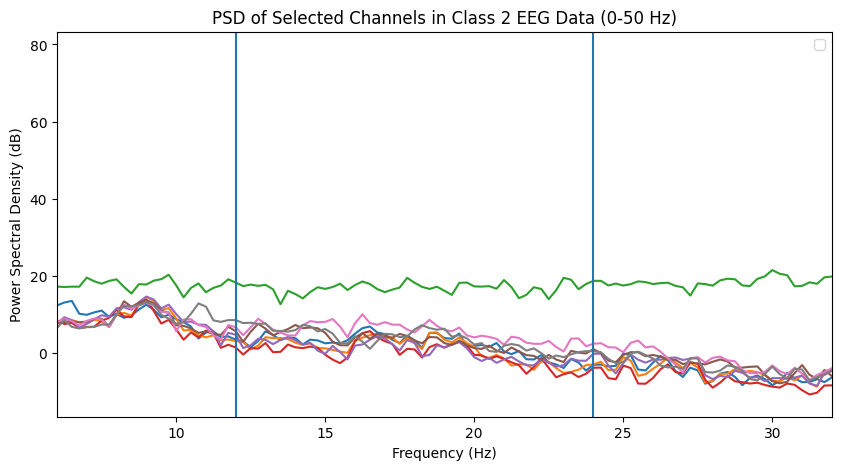

In [156]:
from scipy.signal import butter, lfilter, welch, filtfilt
import numpy as np 
import matplotlib.pyplot as plt
from scipy.signal import welch
# channels_to_use = [0,1,2,3,4,5,6,7,8,9,10]
streams, header = pyxdf.load_xdf("C:/Users/Toey/Desktop/data_ssvep/Toey/exp1/block_1.xdf")
raw_data = streams[0]["time_series"].T #From Steam variable this query is EEG data

channels =['Fz','Cz','P4','Pz','P3','P08','Oz','P07'] #Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*len(channels),
    sfreq= 250 #OpenBCI Frequency acquistion
)
# Create MNE rawarray
raw_mne = mne.io.RawArray(raw_data, info, verbose=False)

x_class2_selected_channels = x
print(x_class2_selected_channels.shape)

# คำนวณ PSD ด้วย scipy.signal.welch สำหรับแต่ละ channel
fs = 250  # สมมติว่า sampling frequency คือ 1000 Hz
fmin, fmax = 6, 50  # กำหนดช่วงความถี่ที่ต้องการ
psds = []
for epoch in x_class2_selected_channels:
    psds_epoch = []
    for channel_data in epoch:
        f, Pxx = welch(channel_data, fs, nperseg=fs*4, noverlap=fs)
        psds_epoch.append(Pxx)
    psds.append(psds_epoch)

# คำนวณค่าเฉลี่ย PSD ในทุก epochs สำหรับแต่ละ channel
psds_mean = np.mean(psds, axis=0)

# กรองความถี่ให้อยู่ในช่วง fmin ถึง fmax
freq_mask = (f >= fmin) & (f <= fmax)
f_filtered = f[freq_mask]
psds_mean_filtered = psds_mean[:, freq_mask]

# plot กราฟ PSD สำหรับแต่ละ channel
plt.figure(figsize=(10, 5))
for i, channel_psd in enumerate(psds_mean_filtered):
    plt.plot(f_filtered, 10 * np.log10(channel_psd))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('PSD of Selected Channels in Class 2 EEG Data (0-50 Hz)')
plt.legend()
plt.xlim([6, 32])
plt.axvline(x=12)
plt.axvline(x=24)
# plt.axvline(x=10)
# plt.axvline(x=14)
# plt.axvline(x=16)
plt.show()


In [144]:
print(len(f))
print(len(Pxx))
data = np.mean(np.mean(x_class2_selected_channels, 0),0)
data.shape

501
501


(5126,)

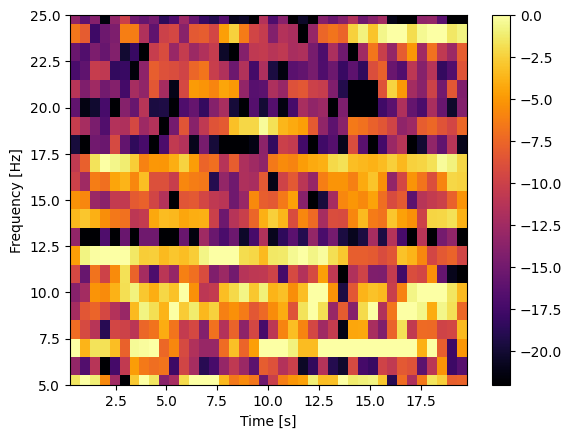

In [155]:
######### Plot time freq #############
from scipy.signal import spectrogram
import numpy as np
fig, ax = plt.subplots()
NFFT = 256
# Pxx, freqs, bins, im = plot.specgram(F8_T8_data, NFFT=NFFT, Fs = sampling_rate, 
#                                     cmap='seismic', noverlap=NFFT/2, vmin = -10, vmax = -10)
f, t, Sxx = spectrogram(data, fs = fs, nperseg= fs, noverlap=NFFT/2)
plt.ylim([5, 25])             # ... set the frequency range,
plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='inferno')   # Plot the result
plt.xlabel('Time [s]')        # ... and label the axes
plt.ylabel('Frequency [Hz]')
plt.colorbar()                # ... with a color bar,
plt.clim([0, -20])
plt.show()


In [146]:
print(Sxx.shape)
f

(126, 40)


array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125.])

In [147]:
import scipy.stats as stats
EEG_zscore = np.zeros((Sxx.shape[0], Sxx.shape[1]))
for i in range(Sxx.shape[0]):
    EEG_zscore[i] = stats.zscore(Sxx[i][:])
print(f'Z-Score Pxx shape is {np.max(EEG_zscore)}')
EEG_zscore = EEG_zscore - np.mean(EEG_zscore)

Z-Score Pxx shape is 4.6604532576934705


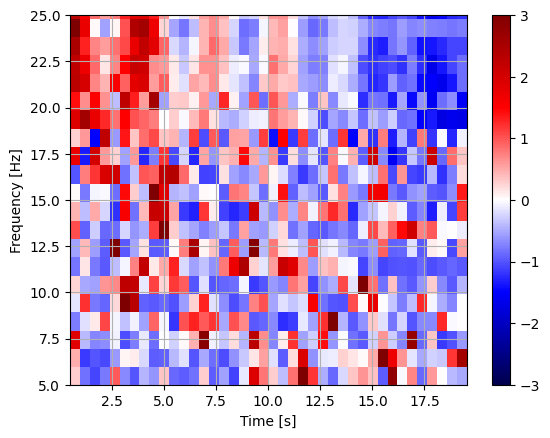

In [148]:
plt.imshow(EEG_zscore, aspect='auto', cmap='seismic', extent=[t.min(), t.max(), f.min(), f.max()])
plt.ylim([5, 25])             # ... set the frequency range,
plt.xlabel('Time [s]')        # ... and label the axes
plt.ylabel('Frequency [Hz]')
plt.grid()
plt.colorbar()                # ... with a color bar,
plt.clim([-3, 3])
plt.show()

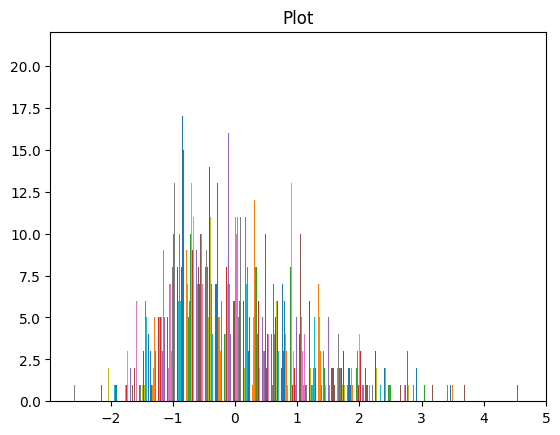

In [149]:
plt.hist(EEG_zscore, bins='auto')
plt.title('Plot')
plt.show()

In [ ]:
from scipy.signal import butter, lfilter, welch, filtfilt
# Create a function to design a filter (function output b, a = filter coefficients)
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs # define nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


In [ ]:
from scipy.signal import butter, lfilter, welch, filtfilt
# Create a function to design a filter (function output b, a = filter coefficients)
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs # define nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


In [ ]:
fs = 250
lowcut = 5
highcut = 20
order = 4
data = x[class1]
b, a = butter_bandpass(lowcut, highcut, fs, order)

filtered_data = filtfilt(b,a, data)
print(filtered_data.shape)


(50, 57, 5126)


In [ ]:
filtered_data = filtered_data[7, :, :]


5126


Text(0.5, 0, 'Hz')

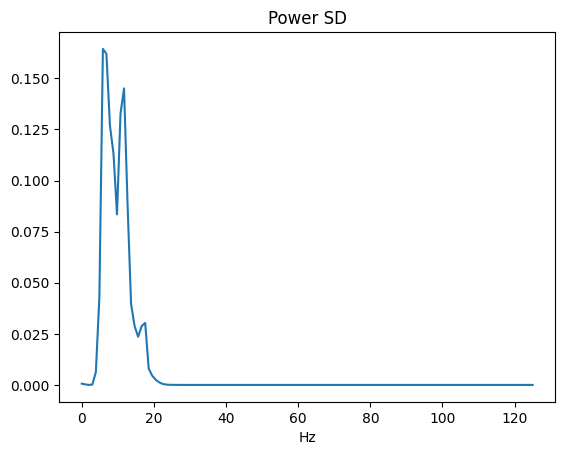

In [ ]:
fs = 250
t = np.arange(0, 20, 1/fs)
# data = np.mean(np.mean(filtered_data, 0), 0)
data = np.mean(filtered_data, 0)

print(len(data))

f, Pxx = welch(data[2000:4000], fs)

plt.figure()
# plt.semilogy(f, Pxx)
plt.plot(f, Pxx)
plt.title('Power SD')
plt.xlabel('Hz')
# plt.xlim([6,15])

5126


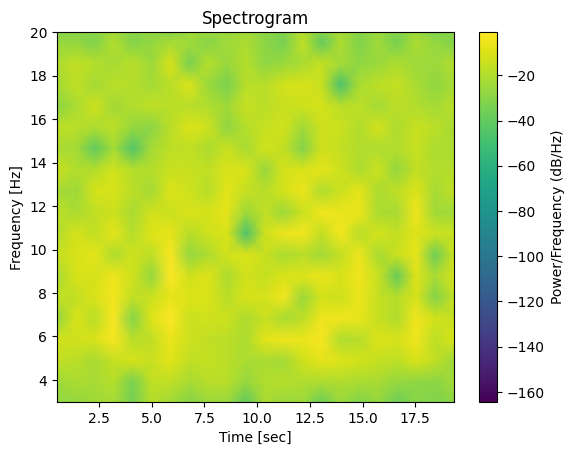

In [ ]:
from scipy.signal import spectrogram

# Compute the spectrogram
start = int(5 * 250)
end = int(10 * 250)
print(len(data))
xlim_dat = data
f_spectrogram, t_spectrogram, Sxx = spectrogram(xlim_dat, fs)

# Plot the spectrogram
plt.figure()
plt.pcolormesh(t_spectrogram, f_spectrogram, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.ylim([3, 20])  # Limit the y-axis to 50 Hz for better visualization
plt.show()